## Sentiment Classification SG Reviews Data (BOW, non-Deep Learning)

This notebook covers two good approaches to perform sentiment classification - Naive Bayes and Logistic Regression. We will train SG reviews data on both.

As a rule of thumb, reviews that are 3 stars and above are **positive**, and vice versa.

In [1]:
%pip install spacy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install gensim

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install spacy_langdetect

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.9 MB 23.0 MB/s eta 0:00:01    |██████                          | 2.6 MB 23.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import random
import pandas as pd
import seaborn as sns
import gensim
import spacy
from collections import Counter, defaultdict
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm

In [6]:
RANDOM_SEED = 33

In [7]:
reviews_sg = pd.read_pickle("assets/sg_reviews.pkl")
reviews_sg.head()

,date,review,rating,app
0,2020-09-30,"Used to be a good app been using for years, no...",5,GrabFood
1,2020-08-21,Grab app is convenient because you can use mul...,1,GrabFood
2,2020-11-18,I used to love the subscription plans that the...,1,GrabFood
3,2021-11-06,I ordered a grabfood and one of the 3 items ar...,1,GrabFood
4,2021-09-26,This platform gives too much power to restaura...,1,GrabFood


In [8]:
reviews_sg['label'] = np.where(reviews_sg['rating'] >= 3, 0, 1)

In [9]:
reviews_sg.head()

,date,review,rating,app,label
0,2020-09-30,"Used to be a good app been using for years, no...",5,GrabFood,0
1,2020-08-21,Grab app is convenient because you can use mul...,1,GrabFood,1
2,2020-11-18,I used to love the subscription plans that the...,1,GrabFood,1
3,2021-11-06,I ordered a grabfood and one of the 3 items ar...,1,GrabFood,1
4,2021-09-26,This platform gives too much power to restaura...,1,GrabFood,1


## 1. Data Processing

Check the dataset size:

In [10]:
print(len(reviews_sg))

659684


And the type of apps:

In [11]:
app_list = list(reviews_sg['app'].unique())
app_list

['GrabFood', 'Deliveroo', 'FoodPanda']

Let's also get a sense of our dataset's balance

In [12]:
reviews_sg['label'].value_counts(normalize=True)

0    0.740038
1    0.259962
Name: label, dtype: float64

In [13]:
# By app

for app in app_list:
    print(reviews_sg[reviews_sg['app'] == app]['label'].value_counts(normalize=True))

0    0.749
1    0.251
Name: label, dtype: float64
0    0.658943
1    0.341057
Name: label, dtype: float64
0    0.747103
1    0.252897
Name: label, dtype: float64


Across the board the distribution of positive and negative reviews are quite consistent between the apps. Overall, there's an imbalance in our dataset, with positive reviews making for 75% of the dataset. Let's also check for null values.

In [14]:
reviews_sg.isnull().sum()

date       0
review    87
rating     0
app        0
label      0
dtype: int64

In [15]:
reviews_sg = reviews_sg.dropna()

In [16]:
df_proc = reviews_sg.copy()
df_proc.drop(columns=['date', 'rating', 'app'], inplace=True)
df_proc.head()

,review,label
0,"Used to be a good app been using for years, no...",0
1,Grab app is convenient because you can use mul...,1
2,I used to love the subscription plans that the...,1
3,I ordered a grabfood and one of the 3 items ar...,1
4,This platform gives too much power to restaura...,1


#### Filter Out Non-English Reviews

In [17]:
# language detection function
def get_lang_detector(nlp, name):
    return LanguageDetector()

# Only run this once, or you need to restart the kernel to avoid errors
Language.factory("language_detector", func=get_lang_detector)

<function __main__.get_lang_detector(nlp, name)>

In [18]:
#init the nlp function and add language detector to the pipeline
nlp = spacy.load("en_core_web_sm")

nlp.add_pipe('language_detector', last=True)

print(nlp.pipe_names)

def lan_detect(x):
    text=str(x)
    with nlp.select_pipes(enable=['parser', 'language_detector']):    
        doc = nlp(text)
        lan_score=doc._.language
    return lan_score['language'], lan_score['score']

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'language_detector']


In [19]:
trial = df_proc.sample(5000)

In [20]:
trial['language'], trial['cof_score'] = zip(*trial['review'].map(lan_detect))

In [21]:
trial=trial[trial['language']=='en']

In [22]:
trial.head()

,review,label,language,cof_score
8262,Much expensive..😔😔,0,en,0.857139
478143,Good in service,0,en,0.999994
294546,Trusted place to get your hungry tummy fed.,0,en,0.999995
112892,Always frozen screen and does not update locat...,1,en,0.999998
202550,This app are suck ! Can you please do not dedu...,1,en,0.999997


In [23]:
len(trial)

2812

Promising! Now let's do the real thing

In [24]:
df_proc['language'], df_proc['cof_score'] = zip(*df_proc['review'].map(lan_detect))

In [25]:
df_proc=df_proc[df_proc['language']=='en']

In [26]:
df_proc.head()

,review,label,language,cof_score
0,"Used to be a good app been using for years, no...",0,en,0.999996
1,Grab app is convenient because you can use mul...,1,en,0.999999
2,I used to love the subscription plans that the...,1,en,0.999999
3,I ordered a grabfood and one of the 3 items ar...,1,en,0.999998
4,This platform gives too much power to restaura...,1,en,0.999998


In [27]:
len(df_proc)

374633

In [28]:
df_proc.to_csv('reviews_sg_filtered.csv')

In [29]:
X = df_proc['review']
y = df_proc['label']

We will split the dataset into `train`, `test`, and `dev`, with 80%, 10%, 10% ratio, respectively.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_SEED)

In [31]:
len(X_train)

299706

In [32]:
len(X_dev)

37464

In [33]:
len(X_test)

37463

In [34]:
X_train.iloc[0]

'Great'

In [35]:
X_test.iloc[0]

'Food pandas have made it very easy to order food and drink.'

## 2.1 Bag-of-Words Approach on Naive Bayes & Logistic Regression

This section explores the use of bag of words as feature extraction. But first, let's have a look at the token frequencies.

In [36]:
# Fill this with any token (with anything in it!) for tokens separated by whitespace
ws_tokens = Counter()

# Fill this one with tokens separated by whitespace but constisting only of tokens
# that are totally made of alphanumeric characters (you can use the \w character
# class in making the regex)

alpha_ws_tokens = Counter()

# Fill this one with the tokens separated by *word boundaries* (not white space) that consist
# of alphanumeric characters (use \w again)
alpha_re_tokens = Counter()
for review in tqdm(X_train):
    ws_review = review.split()
    ws_tokens.update(ws_review)
    # Note: use fullmatch() as it anchor both the start and end of str. match() won't work.
    alpha_ws_tokens.update([re.fullmatch(r'\w+', word).group() for word in ws_review if re.fullmatch(r'\w+', word) != None])
    alpha_re_tokens.update(re.findall(r'\w+', review))

100%|██████████| 299706/299706 [00:11<00:00, 25863.14it/s]


In [37]:
print(len(ws_tokens))
print(len(alpha_ws_tokens))
print(len(alpha_re_tokens))

165065
63237
72797


In [38]:
top_100 = alpha_re_tokens.most_common(100)
top_100

[('the', 147097),
 ('to', 138446),
 ('and', 112056),
 ('I', 95958),
 ('app', 88816),
 ('is', 74236),
 ('it', 65774),
 ('a', 57737),
 ('for', 56861),
 ('order', 54509),
 ('my', 53233),
 ('food', 52984),
 ('of', 44504),
 ('service', 42460),
 ('t', 39624),
 ('in', 38991),
 ('not', 38673),
 ('this', 36329),
 ('but', 36206),
 ('you', 34278),
 ('delivery', 34102),
 ('good', 32641),
 ('time', 30633),
 ('i', 28474),
 ('that', 28243),
 ('on', 28180),
 ('use', 26955),
 ('have', 26541),
 ('they', 26033),
 ('with', 25431),
 ('s', 24581),
 ('was', 24279),
 ('Good', 24096),
 ('me', 23924),
 ('can', 22668),
 ('are', 22482),
 ('very', 21818),
 ('so', 19700),
 ('from', 19434),
 ('be', 18994),
 ('Very', 18728),
 ('your', 18631),
 ('It', 18558),
 ('no', 18460),
 ('The', 18020),
 ('when', 17697),
 ('Great', 16656),
 ('at', 15113),
 ('customer', 14904),
 ('more', 14162),
 ('or', 13663),
 ('up', 13403),
 ('as', 13401),
 ('just', 13397),
 ('get', 13369),
 ('easy', 13111),
 ('all', 12933),
 ('even', 12884),
 

Lots of stopwords, as expected.

In [39]:
x = list(range(100))
y = [word_tup[1] for word_tup in top_100]

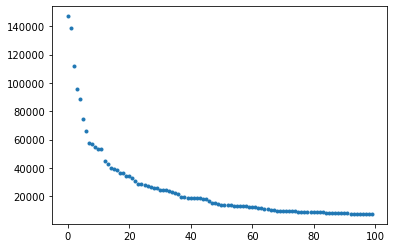

In [40]:
ax = plt.plot(x, y, '.')
#plt.yscale('log')
#plt.xscale('log')

And unexpectedly, the word frequency distribution also follows Zipf's law as well. What that means is that we can essentially remove uncommon words, without worrying that they will affect performance. We will also need to remove stopwords, and add unigrams and bigrams as features.

In [41]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=500, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)

In [42]:
print(X_train_bow.shape)

(299706, 834)


In [43]:
X_dev_bow = vectorizer.transform(X_dev)

In [44]:
def train_model(clf):
    print("_" * 80)
    print("Training: ")
    clf.fit(X_train_bow, y_train)
    y_dev_pred = clf.predict(X_dev_bow)
    
    score = accuracy_score(y_dev, y_dev_pred)
    print("accuracy:   %0.3f" % score)
    
    print("classification report:")
    print(classification_report(y_dev, y_dev_pred))
    
    print("confusion matrix:")
    print(confusion_matrix(y_dev, y_dev_pred))
    print("Training Complete")
    print()
    
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, y_dev_pred

It's training time! We'll start with a few dummy classifiers, followed by Naive Bayes and Logistic Regression.

In [45]:
for clf, name in (
    (DummyClassifier(strategy='uniform', random_state=RANDOM_SEED), "Uniform Classifier"),
    (DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED), "Most Frequent Classifier"),
):
    print("=" * 80)
    print("Training Results - Dummy Classifiers")
    print(name)
    mod = train_model(clf)

Training Results - Dummy Classifiers
Uniform Classifier
________________________________________________________________________________
Training: 
accuracy:   0.499
classification report:
              precision    recall  f1-score   support

           0       0.66      0.50      0.57     24645
           1       0.34      0.50      0.41     12819

    accuracy                           0.50     37464
   macro avg       0.50      0.50      0.49     37464
weighted avg       0.55      0.50      0.51     37464

confusion matrix:
[[12280 12365]
 [ 6402  6417]]
Training Complete

Training Results - Dummy Classifiers
Most Frequent Classifier
________________________________________________________________________________
Training: 
accuracy:   0.658
classification report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.79     24645
           1       0.00      0.00      0.00     12819

    accuracy                           0.66     37464
   

/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/arcts/centos7/python3.8-anaconda/2021.05/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [46]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.867
classification report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     24645
           1       0.79      0.83      0.81     12819

    accuracy                           0.87     37464
   macro avg       0.85      0.86      0.85     37464
weighted avg       0.87      0.87      0.87     37464

confusion matrix:
[[21806  2839]
 [ 2149 10670]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.832
classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     24645
           1       0.79      0.69      0.74     12819

    accuracy                           0.83     37464
   macro avg   

The baseline results are quite promising, with both MultinomialNB and Logistic Regression achieving 0.85 on macro F1-score. This means that the bag-of-word approach is a rather solid approach for sentiment classification. It's also interesting to see that while MultinomialNB has a rather balanced number of false pos and false neg, BernoulliNB and ComplementNB are different. BernoulliNB has a much higher number of fps, while ComplementNB has a much higher number of fns.

Also, according to https://web.stanford.edu/~jurafsky/slp3/4.pdf, using binary NB (BernoulliNB) may improve predictive performance, as whether a word occurs or not seems to matter more than its frequency. But in this case, BernoulliNB does not outperform other Naive Bayes methods. We'll come back to this in a second.

Let's take a look at a few of mis-classifications for both Naive Bayes and Logistic Regression.

In [47]:
# Create a dataframe for mis-classifications
def create_mis_classification_df(name):
    mis_class = pd.DataFrame(X_dev)
    mis_class['Actual'] = y_dev
    mis_class['Predicted'] = preds[name]
    mis_class = mis_class[mis_class['Actual'] != mis_class['Predicted']]
    return mis_class

In [48]:
mis_class_multi = create_mis_classification_df('MultinomialNB')
mis_class_bernoulli = create_mis_classification_df('BernoulliNB')
mis_class_complement = create_mis_classification_df('ComplementNB')
mis_class_logreg = create_mis_classification_df('Logistic Regression')

In [49]:
mis_class_multi.sample(10).values

array([['Trash app', 1, 0],
       ['Do we need to pay as a passenger the highway tollfee here in Philippines?',
        1, 0],
       ['I cant view the drivers plate number in e-receipt or after drop off.',
        0, 1],
       ['service fees ridiculous', 0, 1],
       ['Not working properly since 2 days', 0, 1],
       ['All delivery price raised tooo muxh', 1, 0],
       ['Easy to place order and get it delivered quickly', 0, 1],
       ["It's what it says on the tin.", 0, 1],
       ["I didn't order anything", 0, 1],
       ['This app is too bad to have... It hangs a lot .... "Kutti App"',
        1, 0]], dtype=object)

In [50]:
mis_class_bernoulli.sample(10).values

array([['Released for the United states but when I go to use it it tells me that my country (United states) is not supported.',
        1, 0],
       ["Guys, can you make 'Saved Places' sorted alphabetically? it is hard to find saved-places because the sorting address is messed up. Also, since there are so many similar street names, when picking a new address, the address field should expand automatically down, so i don't have to always guess whether the address details is correct or not.",
        0, 1],
       ['Why i cant update?', 1, 0],
       ["It's good but u need to put the riders contact cuz I once went to the restaurant to pick up the food myself",
        0, 1],
       ['Top road safety measures', 1, 0],
       ["The app itself is good and they usually resolve issues quickly but I feel as though there is little done when it comes to restaurants that repeatedly have issues. For instance we really enjoy pret, but every time we've ordered from them they forget atleast one item.

In [51]:
mis_class_complement.sample(10).values

array([['Explore important turn off', 0, 1],
       ['This app is very bad app this app is not working', 0, 1],
       ["Deliveroo not acting against the racial abuse of its employees, as well as assisting the police on an immigration raid is so far beyond heinous it's impossible to find appropriate words. To call using this service unethical would be an understatement. Even outside of that, it's clunky to use, has far too many easy to accidentally click subscription buttons, and ever-rising delivery prices.",
        1, 0],
       ['Theres a bug. No options fpr the drink. Pls fix. Thanks', 0, 1],
       ['But the workflow needs help.  Why should I need to enter my current location in if I already logged in and have an address on file?  I know I could be in a different area, but give me the option to put a saved address in as well.',
        0, 1],
       ['It should be 24 hrs service , there is no night restaurants like u say all are closed',
        0, 1],
       ['Not user friendly 

In [52]:
mis_class_logreg.sample(10).values

array([["Waiting time when driver have to drop off another passenger first is so off \nthe mark that it's ridiculous. Don't sugarcoat a 15 minutes wait as 5 \nminutes. I understand there could be traffic jams in the morning so work \nout a system where you can get more accurate timing! Bloody hell I would've \nreached work earlier if I took public transport. Wasted my money!",
        0, 1],
       ['No option for senior citizen or PWD discount.', 1, 0],
       ['I have been waiting since 1:30hrs and yet the order is not delivered.... I have ordered it for lunch and I got it for snacks time.... Even the customer service is not responding',
        0, 1],
       ["Can't use pro vouchers. shop.checkout.voucher.validation.invalid error encountered",
        0, 1],
       ['Some of my nearby restaurants are still not available.', 0, 1],
       ["I'm foodpanda fan❤️❤️❤️❤️", 0, 1],
       ['It doesn’t work with latest IOS 11', 0, 1],
       ['Does an alright job but could use a option to mak

Really interesting. Looking at the results, there are a few cases of mis-classifications:
- Reviews that are not in English. Presumably reviews not in English won't be as robust in terms of tokenization and vectorization. (Note: fixed now, but no obvious improvement in performance.)
- Reviews that contain negation expressions, eg "no good" is classified as a positive review when in reality it should be negative. BoW approach makes it hard for ML model to recognize this kind of expressions.
- Reviews that are mis-classified due to rating. Eg a customer may write something negative but give 3 stars. It's tricky in this case because it's a caveat of our dataset.
- Some mis-classification is the ML model being weirdly off, eg ComplementNB classified a "Good" review as negative, or reviews containing the word 'hate' gets classified as positive.
- Contextual awareness is important and this is something that bag-of-word approaches cannot address. For example the sentence 'Very good. Expensive delivery charge though' gets classified as negative likely because of the word expensive, while in reality this is a positive review.

### 2.1 Reduce min_df

We set a min frequency cap of 500. What happens if we reduce this cap to 100?

In [53]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [54]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.879
classification report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     24645
           1       0.80      0.87      0.83     12819

    accuracy                           0.88     37464
   macro avg       0.86      0.88      0.87     37464
weighted avg       0.88      0.88      0.88     37464

confusion matrix:
[[21815  2830]
 [ 1697 11122]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.835
classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     24645
           1       0.80      0.70      0.74     12819

    accuracy                           0.84     37464
   macro avg   

Slight bump in performance, but at the expense of longer training time. 

### 2.2 Not use stopwords removal

In [55]:
vectorizer = TfidfVectorizer(min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [56]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.886
classification report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     24645
           1       0.80      0.90      0.84     12819

    accuracy                           0.89     37464
   macro avg       0.87      0.89      0.88     37464
weighted avg       0.89      0.89      0.89     37464

confusion matrix:
[[21713  2932]
 [ 1343 11476]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.807
classification report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     24645
           1       0.76      0.64      0.70     12819

    accuracy                           0.81     37464
   macro avg   

Performance improved, surprisingly.

### 2.3 Set max_df

In [57]:
vectorizer = TfidfVectorizer(min_df=100, max_df=5000, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [58]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.884
classification report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     24645
           1       0.82      0.85      0.83     12819

    accuracy                           0.88     37464
   macro avg       0.87      0.88      0.87     37464
weighted avg       0.89      0.88      0.88     37464

confusion matrix:
[[22183  2462]
 [ 1898 10921]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.814
classification report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86     24645
           1       0.78      0.64      0.70     12819

    accuracy                           0.81     37464
   macro avg   

Not much changes from stopwords removal.

### 2.4 Clip frequency at 1

Earlier, we see that there isn't any performance with BernoulliNB as compared to other methods. But what if we clip the frequency at the feature processing level? Luckily, sklearn tfidf has a `binary` parameters that allows us to do that.

In [59]:
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1,1))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [60]:
preds = {} # A dict to store our dev set predictions

for clf, name in (
    (MultinomialNB(alpha=0.01), "MultinomialNB"),
    (BernoulliNB(alpha=0.01), "BernoulliNB"),
    (ComplementNB(alpha=0.1), "ComplementNB"),
    (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED), "Logistic Regression")
):
    print("=" * 80)
    print("Training Results - Naive Bayes & LogReg")
    print(name)
    mod = train_model(clf)
    preds[name] = mod[2]

Training Results - Naive Bayes & LogReg
MultinomialNB
________________________________________________________________________________
Training: 
accuracy:   0.871
classification report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     24645
           1       0.79      0.85      0.82     12819

    accuracy                           0.87     37464
   macro avg       0.85      0.86      0.86     37464
weighted avg       0.87      0.87      0.87     37464

confusion matrix:
[[21782  2863]
 [ 1985 10834]]
Training Complete

Training Results - Naive Bayes & LogReg
BernoulliNB
________________________________________________________________________________
Training: 
accuracy:   0.800
classification report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     24645
           1       0.74      0.64      0.69     12819

    accuracy                           0.80     37464
   macro avg   

### 2.5 Tune Logistic Regression Params

So far, LogReg performs the best in terms of macro F1 score. In this section, we'll try tuning the performance of Logistic Regression, using the best Tfidf tuning result above.

In [61]:
vectorizer = TfidfVectorizer(min_df=100, ngram_range=(1,2))
X_train_bow = vectorizer.fit_transform(X_train)
X_dev_bow = vectorizer.transform(X_dev)

In [62]:
clf = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=3000, random_state=RANDOM_SEED)
param_grid = {'C' : np.logspace(-4, 4, 20)}


print("=" * 80)
print("LogReg Grid Search")
clf = GridSearchCV(clf, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train_bow, y_train)
print(clf.best_params_)
y_dev_pred = clf.predict(X_dev_bow)
score = accuracy_score(y_dev, y_dev_pred)
print("accuracy:   %0.3f" % score)
print("classification report:")
print(classification_report(y_dev, y_dev_pred))
print("confusion matrix:")
print(confusion_matrix(y_dev, y_dev_pred))
print("Training Complete")
print()

LogReg Grid Search
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 1.623776739188721}
accuracy:   0.901
classification report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     24645
           1       0.81      0.93      0.87     12819

    accuracy                           0.90     37464
   macro avg       0.88      0.91      0.89     37464
weighted avg       0.91      0.90      0.90     37464

confusion matrix:
[[21845  2800]
 [  911 11908]]
Training Complete

